In [1]:
from google.colab import files
uploaded = files.upload()

Saving monthly_milk_production_1.csv to monthly_milk_production_1 (1).csv


In [2]:
import pandas as pd

df = pd.read_csv('monthly_milk_production_1.csv')
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


# Preprocessing

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df['Production'].values.reshape(-1, 1))

print(df_scaled[:5, :], df_scaled.shape)

[[0.08653846]
 [0.01923077]
 [0.20913462]
 [0.24759615]
 [0.41826923]] (168, 1)


In [4]:
import torch
df_tensor = torch.tensor(df_scaled, dtype=torch.float32)
df_tensor

tensor([[0.0865],
        [0.0192],
        [0.2091],
        [0.2476],
        [0.4183],
        [0.3462],
        [0.2091],
        [0.1106],
        [0.0361],
        [0.0577],
        [0.0000],
        [0.0697],
        [0.1130],
        [0.0312],
        [0.2404],
        [0.2885],
        [0.4543],
        [0.3918],
        [0.2572],
        [0.1538],
        [0.0721],
        [0.0817],
        [0.0288],
        [0.1082],
        [0.1803],
        [0.1562],
        [0.3245],
        [0.3654],
        [0.5216],
        [0.4399],
        [0.3005],
        [0.2067],
        [0.1226],
        [0.1394],
        [0.0986],
        [0.1947],
        [0.2524],
        [0.1659],
        [0.3750],
        [0.4062],
        [0.5505],
        [0.4880],
        [0.3582],
        [0.2404],
        [0.1490],
        [0.1635],
        [0.1178],
        [0.1971],
        [0.2981],
        [0.1971],
        [0.4399],
        [0.4856],
        [0.6202],
        [0.5889],
        [0.4375],
        [0

In [5]:
# Create training and testing sets
training_size: int = int(df_tensor.shape[0] * 0.80)
print(f'training_size = {training_size}')

train_data = df_tensor[:training_size]
test_data = df_tensor[training_size:]
train_data.shape, test_data.shape

training_size = 134


(torch.Size([134, 1]), torch.Size([34, 1]))

In [6]:
import torch.nn as nn
class Model(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=2, dropout=0.2):
    super(Model, self).__init__()
    self.hidden_layer_size = hidden_layer_size
    self.num_layers = num_layers  # Add num_layers as an attribute

    # Stacked LSTM layers with dropout
    self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)

    # Fully connected layer
    self.linear = nn.Linear(hidden_layer_size, output_size)

  def forward(self, x):
    # Initialize the hidden state and cell state with correct dimensions
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)

    # Pass the input through the LSTM layers
    lstm_out, _ = self.lstm(x, (h_0, c_0))

    # Pass the last output of LSTM through the linear layer
    output = self.linear(lstm_out[:, -1, :])

    return output

In [7]:
import numpy as np

def create_sequences(data, time_step=10):
  X, y = [], []
  for i in range(len(data) - time_step):
    X.append(data[i:i + time_step])
    y.append(data[i + time_step])
  return torch.stack(X), torch.stack(y)

time_step = 10
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}')

X_train.shape = torch.Size([124, 10, 1]), y_train.shape = torch.Size([124, 1])
X_test.shape = torch.Size([24, 10, 1]), y_test.shape = torch.Size([24, 1])


# Training the model

In [8]:
model = Model()
criterion = nn.MSELoss()
learning_rate: float = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs: int = 10000
for epoch in range(epochs):
  model.train()

  # Zero gradients
  optimizer.zero_grad()

  # Forward pass
  y_pred = model(X_train)

  # Loss computation
  loss = criterion(y_pred, y_train)

  # Backward pass
  loss.backward()

  # Update parameters
  optimizer.step()

  print(f'Epoch [{epoch + 1}/{epochs}]:\tLoss: {loss.item()}')

Streaming output truncated to the last 5000 lines.
Epoch [5001/10000]:	Loss: 0.0017133723013103008
Epoch [5002/10000]:	Loss: 0.0019581811502575874
Epoch [5003/10000]:	Loss: 0.0019422904588282108
Epoch [5004/10000]:	Loss: 0.0019856905564665794
Epoch [5005/10000]:	Loss: 0.0018543179612606764
Epoch [5006/10000]:	Loss: 0.0016784784384071827
Epoch [5007/10000]:	Loss: 0.001998349092900753
Epoch [5008/10000]:	Loss: 0.001859051175415516
Epoch [5009/10000]:	Loss: 0.0018895805114880204
Epoch [5010/10000]:	Loss: 0.0019176766509190202
Epoch [5011/10000]:	Loss: 0.001968953525647521
Epoch [5012/10000]:	Loss: 0.0017896090866997838
Epoch [5013/10000]:	Loss: 0.0019665672443807125
Epoch [5014/10000]:	Loss: 0.0017863406101241708
Epoch [5015/10000]:	Loss: 0.002068566158413887
Epoch [5016/10000]:	Loss: 0.001918993890285492
Epoch [5017/10000]:	Loss: 0.002088090404868126
Epoch [5018/10000]:	Loss: 0.001940928166732192
Epoch [5019/10000]:	Loss: 0.0017646823544055223
Epoch [5020/10000]:	Loss: 0.0024103503674268

# Testing the model

In [9]:
model.eval()
with torch.no_grad():
  y_pred = model(X_test)
  test_loss = criterion(y_pred, y_test)
  print(f'Test loss: {test_loss.item()}')

Test loss: 0.0015905365580692887


In [10]:
y_pred_scaled = y_pred.cpu().numpy()
y_test_scaled = y_test.cpu().numpy()

y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test_scaled)

print(f'Predicted: {y_pred_original[:5].flatten()}, Actual: {y_test_original[:5].flatten()}')


Predicted: [810.20483 785.55994 883.732   912.66095 964.16376], Actual: [828. 778. 889. 902. 969.]


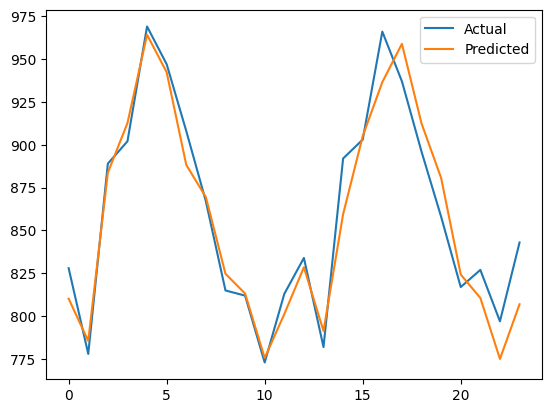

In [11]:
import matplotlib.pyplot as plt

plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.legend()
plt.show()
